# Segmentações

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import csv
import sys
import pandas as pd
import sqlalchemy
import sqlalchemy.orm as orm
import numpy as np
import os
import json
import re
import html
import unicodedata
import ast
from dotenv import load_dotenv
from datetime import datetime
from sqlalchemy import func, case
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

In [3]:
# Importar configuração do banco de dados, modelos e sessão
from database import (
    engine,
    session,
    Base,
    Game,
    Developer,
    Publisher,
    Category,
    Genre,
    Tag,
    Language,
    Screenshot,
    Movie,
    game_tag,
    game_category,
    game_developer,
    game_genre,
    game_language,
    game_publisher,
    test_connection
)

# Testar a conexão com o banco de dados
test_connection()

✅ Conexão com o banco de dados estabelecida com sucesso!


True

In [4]:
# Carregar dados dos jogos do banco de dados
print("Carregando dados dos jogos...")
games_query = session.query(Game).all()

# Converter para DataFrame
games_data = []
for game in games_query:
    # Calcular média de owners estimados
    estimated_owners_avg = (game.estimated_owners_lower + game.estimated_owners_upper) / 2
    
    # Calcular taxa de aprovação (se houver reviews)
    total_reviews = game.positive + game.negative if (game.positive is not None and game.negative is not None) else 0
    approval_rate = (game.positive / total_reviews * 100) if total_reviews > 0 else None
    
    games_data.append({
        'id': game.id,
        'app_id': game.app_id,
        'name': game.name,
        'release_date': game.release_date,
        'estimated_owners_avg': estimated_owners_avg,
        'peak_ccu': game.peak_ccu,
        'price': game.price,
        'discount': game.discount,
        'dlc_count': game.dlc_count,
        'metacritic_score': game.metacritic_score,
        'user_score': game.user_score,
        'positive': game.positive,
        'negative': game.negative,
        'approval_rate': approval_rate,
        'achievements': game.achievements if game.achievements else 0,
        'recommendations': game.recommendations if game.recommendations else 0,
        'average_playtime_forever': game.average_playtime_forever if game.average_playtime_forever else 0,
        'median_playtime_forever': game.median_playtime_forever if game.median_playtime_forever else 0,
        'required_age': game.required_age,
        'windows': 1 if game.windows else 0,
        'mac': 1 if game.mac else 0,
        'linux': 1 if game.linux else 0,
    })

df = pd.DataFrame(games_data)
print(f"Total de jogos carregados: {len(df)}")
print(f"\nShape do DataFrame: {df.shape}")
print(f"\nPrimeiras linhas:")
df.head()

Carregando dados dos jogos...
Total de jogos carregados: 111452

Shape do DataFrame: (111452, 22)

Primeiras linhas:


,id,app_id,name,release_date,estimated_owners_avg,peak_ccu,price,discount,dlc_count,metacritic_score,...,negative,approval_rate,achievements,recommendations,average_playtime_forever,median_playtime_forever,required_age,windows,mac,linux
0,1,20200,Galactic Bowling,2008-10-21,10000.0,0,19.99,0.0,0,0.0,...,11,35.294118,30,0,0,0,0,1,0,0
1,2,655370,Train Bandit,2017-10-12,10000.0,0,0.99,0.0,0,0.0,...,5,91.379310,12,0,0,0,0,1,1,0
2,3,1732930,Jolt Project,2021-11-17,10000.0,0,4.99,0.0,0,0.0,...,0,NaN,0,0,0,0,0,1,0,0
3,4,1355720,Henosis™,2020-07-23,10000.0,0,5.99,0.0,0,0.0,...,0,100.000000,0,0,0,0,0,1,1,1
4,5,1139950,Two Weeks in Painland,2020-02-03,10000.0,0,0.00,0.0,0,0.0,...,8,86.206897,17,0,0,0,0,1,1,0


## Preparação dos Dados para Clustering

In [5]:
# Selecionar features numéricas relevantes para clustering
features_for_clustering = [
    'estimated_owners_avg',
    'peak_ccu',
    'price',
    'discount',
    'dlc_count',
    'metacritic_score',
    'user_score',
    'positive',
    'negative',
    'approval_rate',
    'achievements',
    'recommendations',
    'average_playtime_forever',
    'median_playtime_forever',
    'required_age',
    'windows',
    'mac',
    'linux'
]

# Criar DataFrame apenas com features selecionadas
df_features = df[features_for_clustering].copy()

# Verificar valores nulos
print("Valores nulos por feature:")
print(df_features.isnull().sum())
print(f"\nTotal de linhas: {len(df_features)}")

# Remover linhas com muitos valores nulos (mais de 50% das features importantes)
# Manter apenas jogos com pelo menos algumas métricas importantes
df_features_clean = df_features.dropna(subset=['estimated_owners_avg', 'price', 'peak_ccu'])

print(f"\nLinhas após remover nulos críticos: {len(df_features_clean)}")

# Preencher valores nulos restantes com mediana (mais robusto que média)
imputer = SimpleImputer(strategy='median')
df_features_imputed = pd.DataFrame(
    imputer.fit_transform(df_features_clean),
    columns=df_features_clean.columns,
    index=df_features_clean.index
)

print(f"\nEstatísticas descritivas após imputação:")
df_features_imputed.describe()

Valores nulos por feature:
estimated_owners_avg            0
peak_ccu                        0
price                           0
discount                        0
dlc_count                       0
metacritic_score                0
user_score                      0
positive                        0
negative                        0
approval_rate               37588
achievements                    0
recommendations                 0
average_playtime_forever        0
median_playtime_forever         0
required_age                    0
windows                         0
mac                             0
linux                           0
dtype: int64

Total de linhas: 111452

Linhas após remover nulos críticos: 111452

Estatísticas descritivas após imputação:


,estimated_owners_avg,peak_ccu,price,discount,dlc_count,metacritic_score,user_score,positive,negative,approval_rate,achievements,recommendations,average_playtime_forever,median_playtime_forever,required_age,windows,mac,linux
count,1.114520e+05,1.114520e+05,111452.000000,111452.000000,111452.000000,111452.000000,111452.000000,1.114520e+05,111452.000000,111452.000000,111452.000000,1.114520e+05,111452.000000,111452.000000,111452.000000,111452.000000,111452.000000,111452.000000
mean,6.864215e+04,1.777215e+02,7.061568,0.464209,0.449530,2.623354,0.030408,7.543525e+02,125.859177,78.661719,17.511144,6.163715e+02,81.247290,72.651330,0.254208,0.999704,0.173851,0.122797
std,9.270899e+05,8.390462e+03,12.563246,3.503658,12.006677,13.736245,1.565136,2.139410e+04,4002.844431,20.644904,150.139008,1.573854e+04,999.935906,1321.333137,2.035653,0.017205,0.378983,0.328206
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+04,0.000000e+00,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,75.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000e+04,0.000000e+00,3.990000,0.000000,0.000000,0.000000,0.000000,3.000000e+00,1.000000,83.333333,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000e+04,1.000000e+00,9.990000,0.000000,0.000000,0.000000,0.000000,2.900000e+01,8.000000,90.000000,17.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.500000e+08,1.311366e+06,999.980000,92.000000,2366.000000,97.000000,100.000000,5.764420e+06,895978.000000,100.000000,9821.000000,3.441592e+06,145727.000000,208473.000000,21.000000,1.000000,1.000000,1.000000


In [6]:
# Normalizar os dados (importante para clustering)
# Usar RobustScaler que é mais resistente a outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_features_imputed)

# Converter de volta para DataFrame para facilitar análise
X_scaled_df = pd.DataFrame(X_scaled, columns=df_features_imputed.columns, index=df_features_imputed.index)

print("Dados normalizados:")
print(X_scaled_df.describe())

# Verificar se há valores infinitos ou NaN
print(f"\nValores infinitos: {np.isinf(X_scaled).sum()}")
print(f"Valores NaN: {np.isnan(X_scaled).sum()}")

Dados normalizados:
       estimated_owners_avg      peak_ccu          price       discount  \
count          1.114520e+05  1.114520e+05  111452.000000  111452.000000   
mean           5.864215e+04  1.777215e+02       0.341285       0.464209   
std            9.270899e+05  8.390462e+03       1.395916       3.503658   
min           -1.000000e+04  0.000000e+00      -0.443333       0.000000   
25%            0.000000e+00  0.000000e+00      -0.333333       0.000000   
50%            0.000000e+00  0.000000e+00       0.000000       0.000000   
75%            0.000000e+00  1.000000e+00       0.666667       0.000000   
max            1.499900e+08  1.311366e+06     110.665556      92.000000   

           dlc_count  metacritic_score     user_score       positive  \
count  111452.000000     111452.000000  111452.000000  111452.000000   
mean        0.449530          2.623354       0.030408      25.908708   
std        12.006677         13.736245       1.565136     737.727522   
min         0.00

## Determinar Número Ótimo de Clusters

Calculando métricas para diferentes números de clusters...
  K=3 concluído...
  K=6 concluído...
  K=9 concluído...
  K=12 concluído...


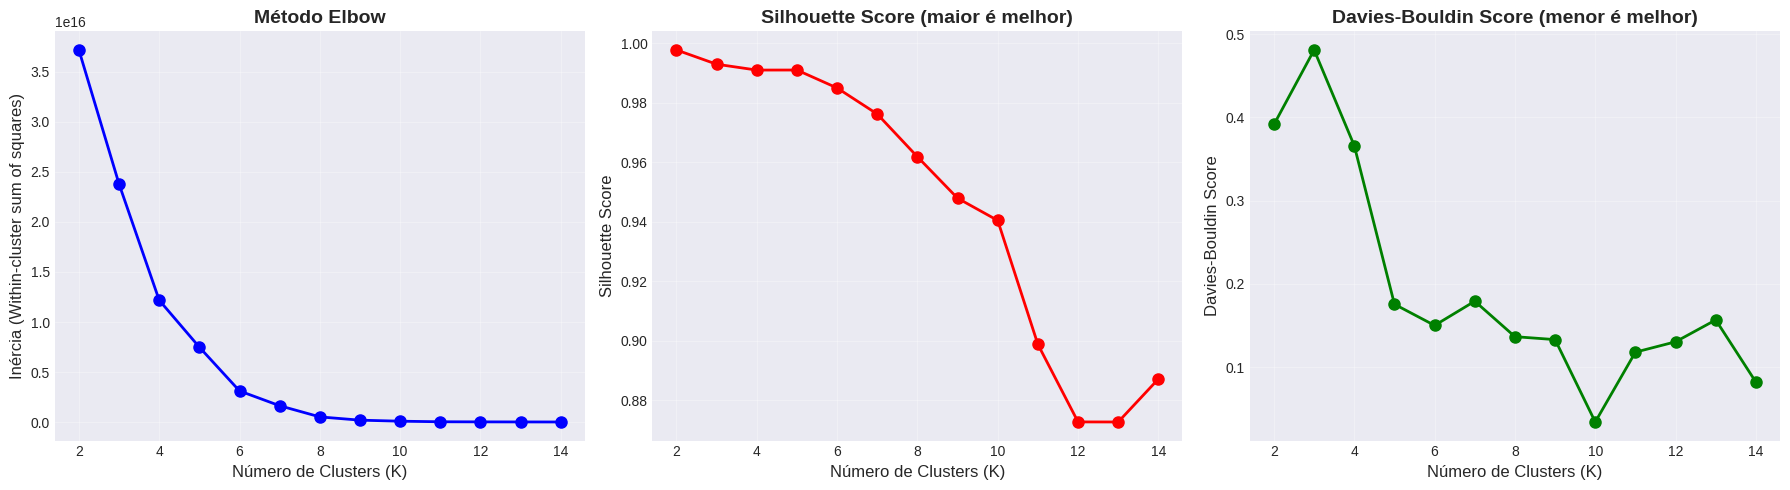


K ótimo baseado em Silhouette Score: 2 (score: 0.9977)
K ótimo baseado em Davies-Bouldin Score: 10 (score: 0.0343)

Usando K = 2 para o clustering final


In [7]:
# Método Elbow para determinar número ótimo de clusters
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 15)

print("Calculando métricas para diferentes números de clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    
    if k % 3 == 0:
        print(f"  K={k} concluído...")

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow Method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inércia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Método Elbow', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score (maior é melhor)
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score (maior é melhor)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin Score (menor é melhor)
axes[2].plot(K_range, davies_bouldin_scores, 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[2].set_title('Davies-Bouldin Score (menor é melhor)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar K ótimo baseado nas métricas
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_davies = K_range[np.argmin(davies_bouldin_scores)]

print(f"\nK ótimo baseado em Silhouette Score: {optimal_k_silhouette} (score: {max(silhouette_scores):.4f})")
print(f"K ótimo baseado em Davies-Bouldin Score: {optimal_k_davies} (score: {min(davies_bouldin_scores):.4f})")

# Usar o K com melhor silhouette score
optimal_k = optimal_k_silhouette
print(f"\nUsando K = {optimal_k} para o clustering final")

## Aplicar K-Means Clustering

In [8]:
# Aplicar K-Means com o número ótimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
cluster_labels = kmeans.fit_predict(X_scaled)

# Adicionar labels de cluster ao DataFrame original
df_clustered = df_features_imputed.copy()
df_clustered['cluster'] = cluster_labels

# Adicionar também ao DataFrame completo para análise
df_with_clusters = df.loc[df_features_imputed.index].copy()
df_with_clusters['cluster'] = cluster_labels

print(f"Clustering concluído!")
print(f"\nDistribuição dos clusters:")
print(df_clustered['cluster'].value_counts().sort_index())

print(f"\nMétricas finais:")
print(f"  Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.4f}")
print(f"  Davies-Bouldin Score: {davies_bouldin_score(X_scaled, cluster_labels):.4f}")
print(f"  Inércia: {kmeans.inertia_:.2f}")

Clustering concluído!

Distribuição dos clusters:
cluster
0    111425
1        27
Name: count, dtype: int64

Métricas finais:
  Silhouette Score: 0.9977
  Davies-Bouldin Score: 0.3915
  Inércia: 37179227579128096.00


## Análise dos Clusters

In [9]:
# Estatísticas descritivas por cluster
print("Estatísticas descritivas por cluster:")
print("=" * 80)

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} jogos ({len(cluster_data)/len(df_clustered)*100:.2f}%)")
    print(f"{'='*80}")
    
    # Mostrar médias das features mais importantes
    important_features = [
        'estimated_owners_avg', 'peak_ccu', 'price', 'metacritic_score',
        'approval_rate', 'average_playtime_forever', 'achievements', 'recommendations'
    ]
    
    print("\nMédias das features principais:")
    for feature in important_features:
        if feature in cluster_data.columns:
            mean_val = cluster_data[feature].mean()
            if feature in ['estimated_owners_avg', 'peak_ccu', 'positive', 'negative', 
                          'achievements', 'recommendations', 'average_playtime_forever']:
                print(f"  {feature:30s}: {mean_val:>15,.0f}")
            elif feature in ['price', 'discount', 'metacritic_score', 'user_score', 'approval_rate']:
                print(f"  {feature:30s}: {mean_val:>15.2f}")
            else:
                print(f"  {feature:30s}: {mean_val:>15.2f}")

# Criar DataFrame com médias por cluster para visualização
cluster_summary = df_clustered.groupby('cluster')[features_for_clustering].mean()
print("\n\nResumo das médias por cluster:")
cluster_summary

Estatísticas descritivas por cluster:

CLUSTER 0 - 111425 jogos (99.98%)

Médias das features principais:
  estimated_owners_avg          :          57,351
  peak_ccu                      :             138
  price                         :            7.06
  metacritic_score              :            2.61
  approval_rate                 :           78.66
  average_playtime_forever      :              79
  achievements                  :              17
  recommendations               :             501

CLUSTER 1 - 27 jogos (0.02%)

Médias das features principais:
  estimated_owners_avg          :      46,666,667
  peak_ccu                      :         164,168
  price                         :           10.66
  metacritic_score              :           49.52
  approval_rate                 :           86.69
  average_playtime_forever      :           9,074
  achievements                  :             130
  recommendations               :         478,138


Resumo das médias por cluster

,estimated_owners_avg,peak_ccu,price,discount,dlc_count,metacritic_score,user_score,positive,negative,approval_rate,achievements,recommendations,average_playtime_forever,median_playtime_forever,required_age,windows,mac,linux
cluster,,,,,,,,,,,,,,,,,,
0,5.735073e+04,137.984214,7.060695,0.464321,0.448095,2.611990,0.030415,572.587893,96.412232,78.659774,17.483922,500.660713,79.068288,72.243778,0.253202,0.999704,0.173785,0.122728
1,4.666667e+07,164167.814815,10.662222,0.000000,6.370370,49.518519,0.000000,750870.074074,121649.037037,86.688441,129.851852,478137.666667,9073.666667,1754.555556,4.407407,1.000000,0.444444,0.407407


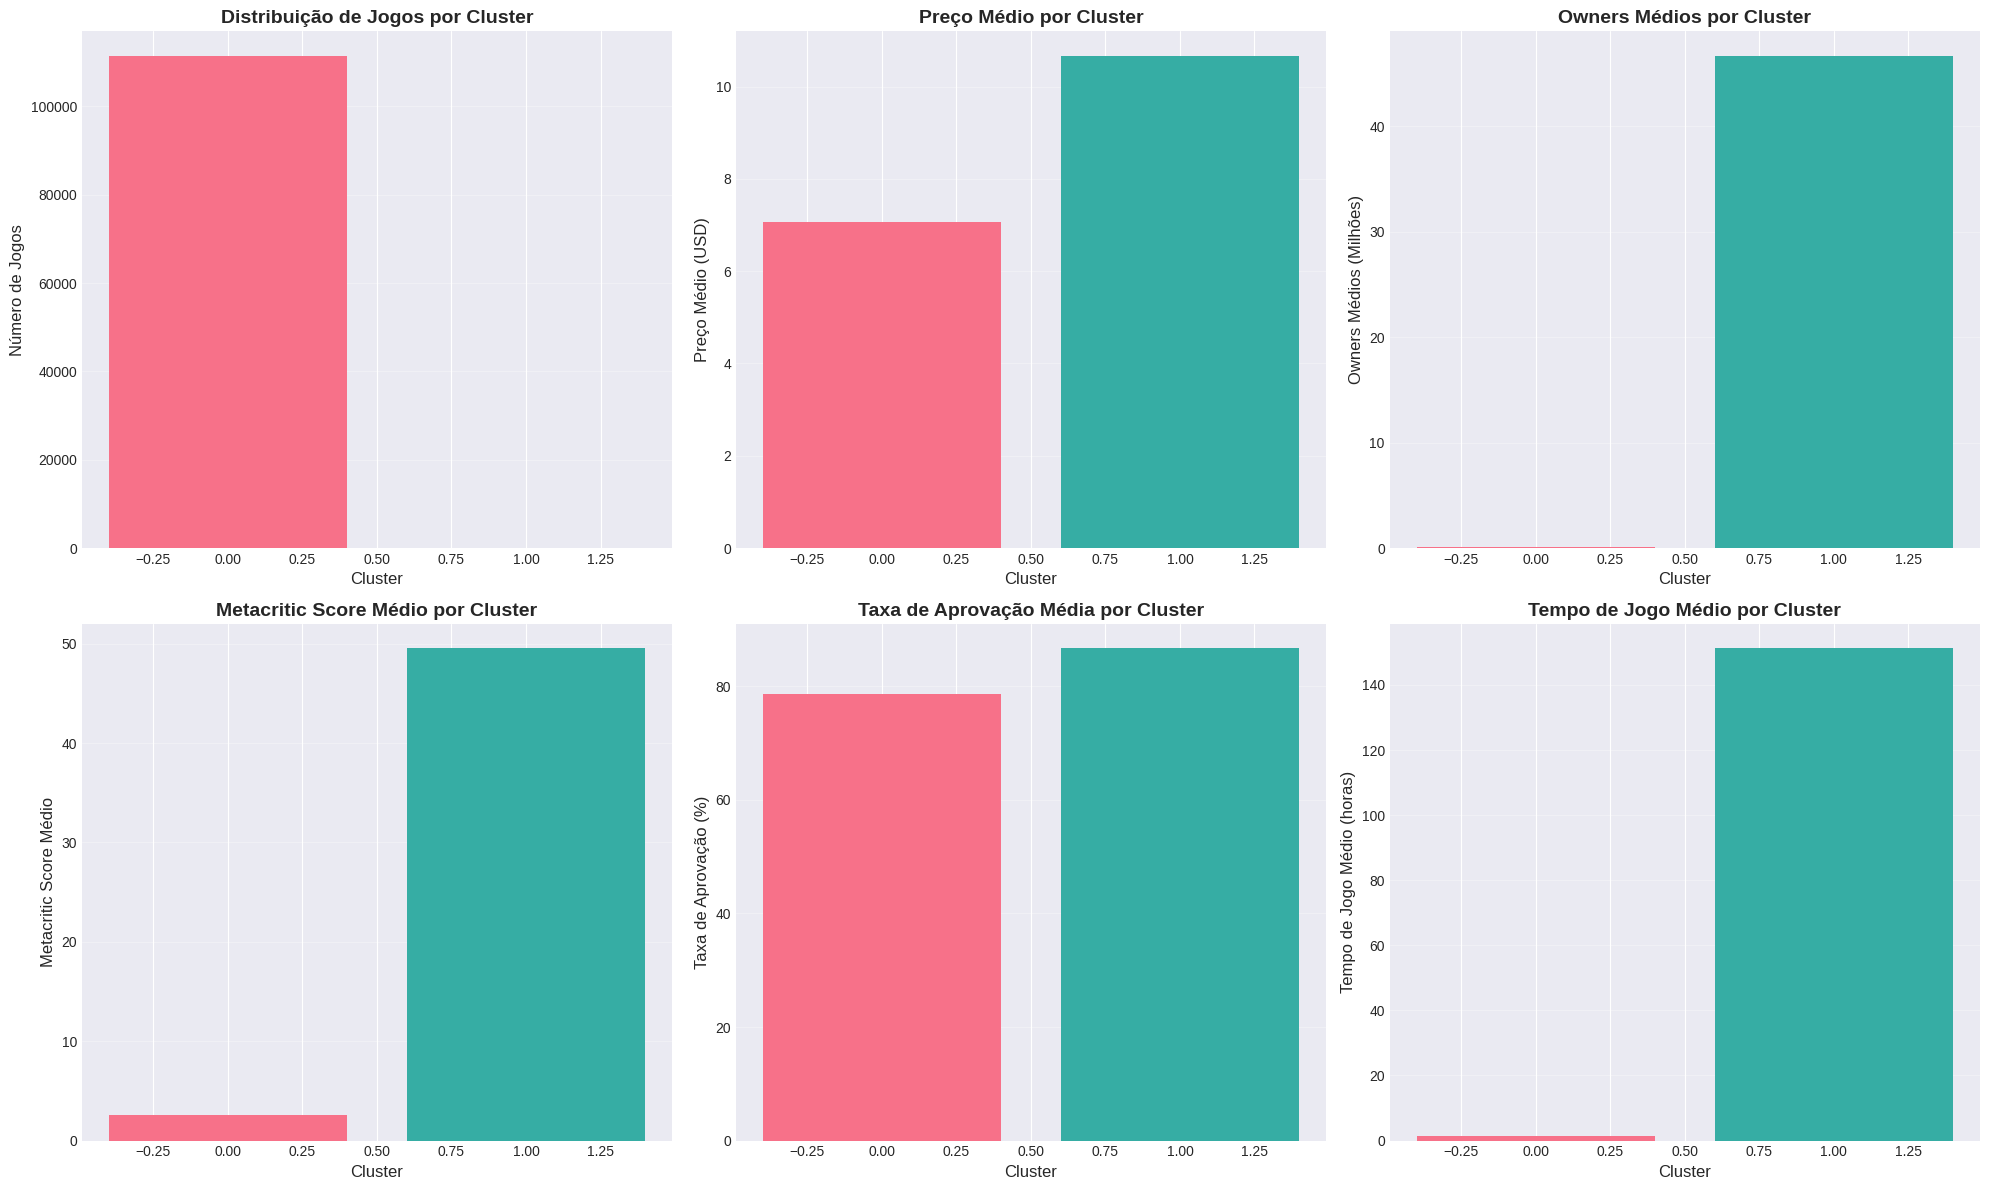

In [10]:
# Visualizar características dos clusters em gráficos
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Distribuição de clusters
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color=sns.color_palette("husl", len(cluster_counts)))
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Número de Jogos', fontsize=12)
axes[0, 0].set_title('Distribuição de Jogos por Cluster', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Preço médio por cluster
price_by_cluster = df_clustered.groupby('cluster')['price'].mean().sort_index()
axes[0, 1].bar(price_by_cluster.index, price_by_cluster.values, color=sns.color_palette("husl", len(price_by_cluster)))
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Preço Médio (USD)', fontsize=12)
axes[0, 1].set_title('Preço Médio por Cluster', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Owners médios por cluster (em milhões)
owners_by_cluster = df_clustered.groupby('cluster')['estimated_owners_avg'].mean().sort_index() / 1e6
axes[0, 2].bar(owners_by_cluster.index, owners_by_cluster.values, color=sns.color_palette("husl", len(owners_by_cluster)))
axes[0, 2].set_xlabel('Cluster', fontsize=12)
axes[0, 2].set_ylabel('Owners Médios (Milhões)', fontsize=12)
axes[0, 2].set_title('Owners Médios por Cluster', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Metacritic Score médio por cluster
metacritic_by_cluster = df_clustered.groupby('cluster')['metacritic_score'].mean().sort_index()
axes[1, 0].bar(metacritic_by_cluster.index, metacritic_by_cluster.values, color=sns.color_palette("husl", len(metacritic_by_cluster)))
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Metacritic Score Médio', fontsize=12)
axes[1, 0].set_title('Metacritic Score Médio por Cluster', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Taxa de aprovação média por cluster
approval_by_cluster = df_clustered.groupby('cluster')['approval_rate'].mean().sort_index()
axes[1, 1].bar(approval_by_cluster.index, approval_by_cluster.values, color=sns.color_palette("husl", len(approval_by_cluster)))
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Taxa de Aprovação (%)', fontsize=12)
axes[1, 1].set_title('Taxa de Aprovação Média por Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Tempo de jogo médio por cluster (em horas)
playtime_by_cluster = df_clustered.groupby('cluster')['average_playtime_forever'].mean().sort_index() / 60
axes[1, 2].bar(playtime_by_cluster.index, playtime_by_cluster.values, color=sns.color_palette("husl", len(playtime_by_cluster)))
axes[1, 2].set_xlabel('Cluster', fontsize=12)
axes[1, 2].set_ylabel('Tempo de Jogo Médio (horas)', fontsize=12)
axes[1, 2].set_title('Tempo de Jogo Médio por Cluster', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Visualização dos Clusters com PCA

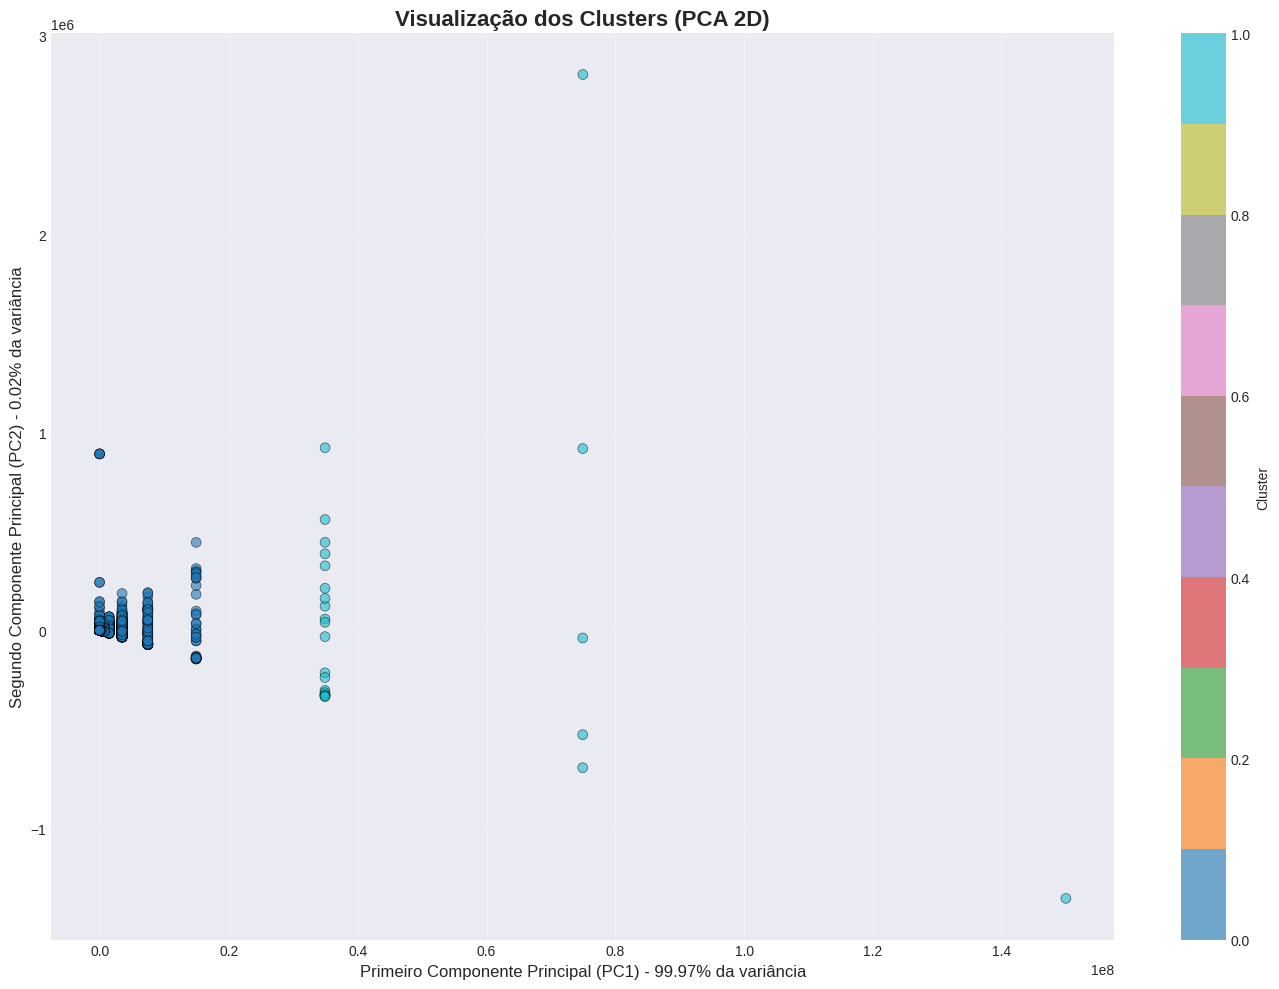

Variância explicada pelo PC1: 99.97%
Variância explicada pelo PC2: 0.02%
Variância total explicada: 99.99%


In [11]:
# Reduzir dimensionalidade com PCA para visualização 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Criar DataFrame com coordenadas PCA
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_clustered.index)
pca_df['cluster'] = cluster_labels

# Visualizar clusters em 2D
plt.figure(figsize=(14, 10))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], 
                     cmap='tab10', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

plt.xlabel(f'Primeiro Componente Principal (PC1) - {pca.explained_variance_ratio_[0]*100:.2f}% da variância', 
           fontsize=12)
plt.ylabel(f'Segundo Componente Principal (PC2) - {pca.explained_variance_ratio_[1]*100:.2f}% da variância', 
           fontsize=12)
plt.title('Visualização dos Clusters (PCA 2D)', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Variância explicada pelo PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variância explicada pelo PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_)*100:.2f}%")

## Análise Detalhada de Cada Cluster

In [12]:
# Analisar características distintivas de cada cluster
print("=" * 100)
print("ANÁLISE DETALHADA DOS CLUSTERS")
print("=" * 100)

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    cluster_games = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    print(f"\n{'='*100}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*100}")
    print(f"Total de jogos: {len(cluster_data)} ({len(cluster_data)/len(df_clustered)*100:.2f}% do total)")
    
    # Características principais
    print(f"\n📊 CARACTERÍSTICAS PRINCIPAIS:")
    print(f"  • Owners médios: {cluster_data['estimated_owners_avg'].mean()/1e6:.2f} milhões")
    print(f"  • Peak CCU médio: {cluster_data['peak_ccu'].mean():,.0f} jogadores")
    print(f"  • Preço médio: ${cluster_data['price'].mean():.2f}")
    print(f"  • Desconto médio: {cluster_data['discount'].mean():.1f}%")
    print(f"  • Metacritic Score médio: {cluster_data['metacritic_score'].mean():.1f}")
    print(f"  • Taxa de aprovação média: {cluster_data['approval_rate'].mean():.1f}%")
    print(f"  • Tempo de jogo médio: {cluster_data['average_playtime_forever'].mean()/60:.1f} horas")
    print(f"  • Achievements médios: {cluster_data['achievements'].mean():.0f}")
    print(f"  • Recomendações médias: {cluster_data['recommendations'].mean():,.0f}")
    print(f"  • DLCs médios: {cluster_data['dlc_count'].mean():.1f}")
    
    # Plataformas
    print(f"\n💻 PLATAFORMAS:")
    print(f"  • Windows: {cluster_data['windows'].mean()*100:.1f}%")
    print(f"  • Mac: {cluster_data['mac'].mean()*100:.1f}%")
    print(f"  • Linux: {cluster_data['linux'].mean()*100:.1f}%")
    
    # Top jogos do cluster (por owners)
    print(f"\n🎮 TOP 5 JOGOS DO CLUSTER (por owners):")
    top_games = cluster_games.nlargest(5, 'estimated_owners_avg')[['name', 'estimated_owners_avg', 'price', 'metacritic_score']]
    for idx, (_, game) in enumerate(top_games.iterrows(), 1):
        owners_millions = game['estimated_owners_avg'] / 1e6
        print(f"  {idx}. {game['name'][:60]:60s} | Owners: {owners_millions:6.2f}M | Preço: ${game['price']:6.2f} | Metacritic: {game['metacritic_score']:.0f}")
    
    print()

ANÁLISE DETALHADA DOS CLUSTERS

CLUSTER 0
Total de jogos: 111425 (99.98% do total)

📊 CARACTERÍSTICAS PRINCIPAIS:
  • Owners médios: 0.06 milhões
  • Peak CCU médio: 138 jogadores
  • Preço médio: $7.06
  • Desconto médio: 0.5%
  • Metacritic Score médio: 2.6
  • Taxa de aprovação média: 78.7%
  • Tempo de jogo médio: 1.3 horas
  • Achievements médios: 17
  • Recomendações médias: 501
  • DLCs médios: 0.4

💻 PLATAFORMAS:
  • Windows: 100.0%
  • Mac: 17.4%
  • Linux: 12.3%

🎮 TOP 5 JOGOS DO CLUSTER (por owners):
  1. 鬼谷八荒 Tale of Immortal                                        | Owners:  15.00M | Preço: $ 19.99 | Metacritic: 0
  2. ARK: Survival Evolved                                        | Owners:  15.00M | Preço: $ 29.99 | Metacritic: 70
  3. Cyberpunk 2077                                               | Owners:  15.00M | Preço: $ 59.99 | Metacritic: 86
  4. World of Tanks Blitz                                         | Owners:  15.00M | Preço: $  0.00 | Metacritic: 0
  5. Black Sq

## Heatmap de Características por Cluster

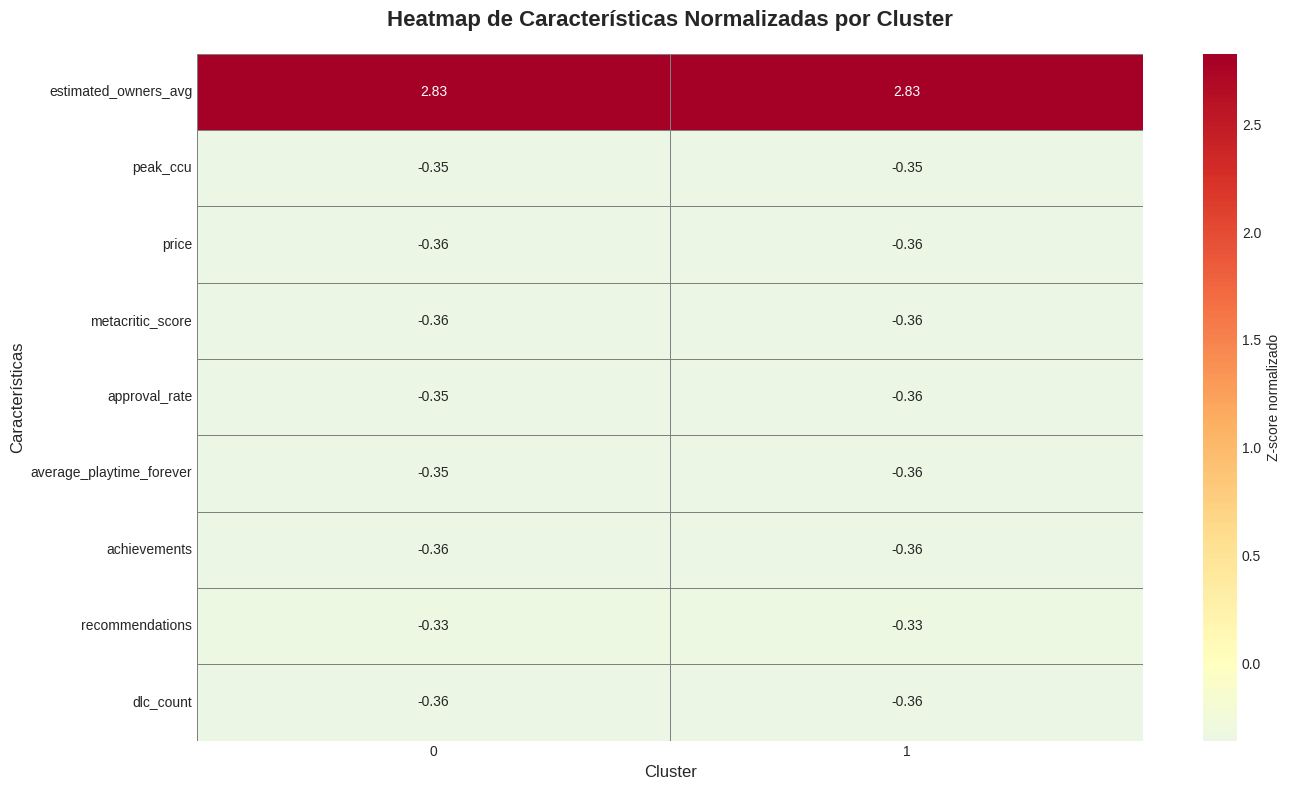

: 

In [ ]:
# Normalizar os dados do cluster_summary para visualização no heatmap
# Usar z-score para cada feature
from sklearn.preprocessing import StandardScaler

# Selecionar features numéricas principais para o heatmap
heatmap_features = [
    'estimated_owners_avg', 'peak_ccu', 'price', 'metacritic_score',
    'approval_rate', 'average_playtime_forever', 'achievements', 
    'recommendations', 'dlc_count'
]

cluster_summary_heatmap = cluster_summary[heatmap_features].copy()

# Normalizar cada coluna (feature) para melhor visualização
scaler_heatmap = StandardScaler()
cluster_summary_normalized = pd.DataFrame(
    scaler_heatmap.fit_transform(cluster_summary_heatmap.T).T,
    columns=cluster_summary_heatmap.columns,
    index=cluster_summary_heatmap.index
)

# Criar heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_summary_normalized.T, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, cbar_kws={'label': 'Z-score normalizado'}, 
            linewidths=0.5, linecolor='gray')
plt.title('Heatmap de Características Normalizadas por Cluster', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.tight_layout()
plt.show()

## Tentativa com DBSCAN (Clustering Baseado em Densidade)

In [ ]:
# DBSCAN pode encontrar clusters de forma não supervisionada
# Mas é sensível aos parâmetros eps e min_samples
# Vamos tentar alguns valores

# Reduzir dimensionalidade primeiro para melhor performance e visualização
pca_dbscan = PCA(n_components=10, random_state=42)  # Manter mais componentes para DBSCAN
X_pca_dbscan = pca_dbscan.fit_transform(X_scaled)

print(f"Variância explicada com 10 componentes: {sum(pca_dbscan.explained_variance_ratio_)*100:.2f}%")

# Tentar diferentes valores de eps
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples = 10

results_dbscan = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels_dbscan = dbscan.fit_predict(X_pca_dbscan)
    
    n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    n_noise = list(labels_dbscan).count(-1)
    
    if n_clusters > 0:
        # Calcular silhouette apenas para pontos não-ruído
        mask = labels_dbscan != -1
        if sum(mask) > 1:
            silhouette = silhouette_score(X_pca_dbscan[mask], labels_dbscan[mask])
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    results_dbscan.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette
    })
    
    print(f"eps={eps:3.1f}: {n_clusters:2d} clusters, {n_noise:5d} pontos de ruído, silhouette={silhouette:.4f}")

# Escolher melhor configuração
best_dbscan = max(results_dbscan, key=lambda x: x['silhouette'] if x['n_clusters'] > 0 else -1)
print(f"\nMelhor configuração: eps={best_dbscan['eps']}")

# Aplicar DBSCAN com melhor configuração
dbscan_final = DBSCAN(eps=best_dbscan['eps'], min_samples=min_samples)
labels_dbscan_final = dbscan_final.fit_predict(X_pca_dbscan)

n_clusters_dbscan = len(set(labels_dbscan_final)) - (1 if -1 in labels_dbscan_final else 0)
n_noise_dbscan = list(labels_dbscan_final).count(-1)

print(f"\nResultado final DBSCAN:")
print(f"  Número de clusters: {n_clusters_dbscan}")
print(f"  Pontos de ruído: {n_noise_dbscan} ({n_noise_dbscan/len(labels_dbscan_final)*100:.2f}%)")

# Visualizar DBSCAN em 2D
pca_2d_dbscan = PCA(n_components=2, random_state=42)
X_pca_2d_dbscan = pca_2d_dbscan.fit_transform(X_scaled)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_pca_2d_dbscan[:, 0], X_pca_2d_dbscan[:, 1], 
                     c=labels_dbscan_final, cmap='tab10', alpha=0.6, 
                     s=50, edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 - {pca_2d_dbscan.explained_variance_ratio_[0]*100:.2f}%', fontsize=12)
plt.ylabel(f'PC2 - {pca_2d_dbscan.explained_variance_ratio_[1]*100:.2f}%', fontsize=12)
plt.title(f'Clusters DBSCAN (eps={best_dbscan["eps"]}, {n_clusters_dbscan} clusters, {n_noise_dbscan} ruído)', 
          fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Variância explicada com 10 componentes: 100.00%
eps=0.5: 64 clusters, 27469 pontos de ruído, silhouette=0.3533
eps=1.0: 33 clusters, 24420 pontos de ruído, silhouette=0.4256


## Salvar Resultados do Clustering

In [ ]:
# Salvar DataFrame com clusters para análise posterior
df_final = df_with_clusters.copy()

# Adicionar informações adicionais úteis
df_final['owners_millions'] = df_final['estimated_owners_avg'] / 1e6
df_final['playtime_hours'] = df_final['average_playtime_forever'] / 60

# Salvar em CSV
output_file = 'datasets/games_with_clusters.csv'
df_final.to_csv(output_file, index=False)
print(f"Resultados salvos em: {output_file}")
print(f"Total de jogos: {len(df_final)}")
print(f"Colunas: {list(df_final.columns)}")

# Mostrar resumo final
print("\n" + "="*80)
print("RESUMO FINAL DA SEGMENTAÇÃO")
print("="*80)
print(f"\nNúmero de clusters encontrados: {optimal_k}")
print(f"Total de jogos segmentados: {len(df_final)}")
print(f"\nDistribuição por cluster:")
print(df_final['cluster'].value_counts().sort_index())
print("\n✅ Análise de segmentação concluída!")